## 計測バッチ処理プログラム

中心軸の上端と末端の位置を指定し、あとは自動。（近似次数、サンプル数、精度など個別指定できるが、デフォルトで良い）


**Usage**:

    automeasure(datafile = '計測指示＆記録.xlsx', savedir='伸身シルエットR', saveImage=True)
　
**パラメータ**
>    **savedir** 保存先フォルダのパス   
>    **datafile** バッチ司令のエクセルファイル。結果の保存先でもある。  
>    **saveImage** 画像を保存するかどうかのフラグ

処理パラメータ等を記載した Excel のファイルを用意する。各行は個体、列は指示及び計測結果となる属性

入力項目

## 測量のための設定項目
|カラム|内容|
|:---:|:---|
|memo|メモ欄|
|topdir|画像のあるフォルダ名|
|subdir|サブフォルダ名|
|filename|ファイル名|
|rename|保存ファイル名|
|処理対象|処理対象とするかどうかのチェック欄　１なら処理する|
|M|仮近似に用いるベジエ曲線の次数（このプログラムでは使わない）|
|N|輪郭線の近似に用いるベジエ曲線の次数|
|C|中心軸の近似に用いるベジエ曲線の次数|
|L|伸身形状の記述に用いるベジエ曲線の次数|
|precPara1|仮近似のパラメータ推定に要求する精度（このプログラムでは使わない）|
|precPara2|本近似のパラメータ推定に要求する精度|

## カスタムパラメータ
個体ごとに設定するパラメータ。大文字の項目は「軸の端点指定ツール」を用いて入力。

|カラム|内容|
|:---:|:---|
|TOPDX|中心軸の上端点のX座標）|
|TOPDY|同じく、Y座標|
|TOPDR|上端削除半径　上端部が凸凹している場合は大きめに設定すべき|
|BTMDX|中心軸の下端点のX座標）|
|BTMDY|同じく、Y座標|
|BTMDR|上端削除半径　根の部分が凸凹している場合は大きめに設定すべき|
|n_samples1|仮近似に使う輪郭点サンプル数(このプログラムでは使わない)|
|n_samples2|本近似と伸身形状の近似に使うサンプル数|

## 計測結果
|カラム|内容|
|:---:|:---|
|長さ|ピクセルで測った長さ。伸身復元曲線でY軸方向を測定。頭頂からはば２０％の位置までの長さ|
|最大径|ピクセルで測った最大径。伸身復元曲線のx軸方向の幅の最大値である|
|最大径位置|最大径の位置が、長さに対して上から何％の位置であるかを％で記録|
|最大径位置のt値|近似ベジエ曲線における最大径位置のパラメータ|
|径20％位置のt値|同じく、最大径の２０％となる位置のパラメータ|
|誤差|近似対象部分を描いた図形と近似対象部分のシルエットのずれの総和(画素数）|
|近似対象面積|この面積には上下の削除された部分は含まれない|
|近似対象輪郭画素数|近似対象となった輪郭画素数|
|SXn,SYn|伸身形状のベジエ曲線の制御点。制御点により曲線形状が計算できる|
|CXn,CYn|輪郭から計算された中心軸のベジエ曲線の制御点|
|LXn,LYn|左輪郭を近似するベジエ曲線の制御点|
|RXn,RYn|右輪郭を近似するベジエ曲線の制御点|

## 補足
- 最初の配置時のバウンダリボックスの縦の長さが256になるよう正規化して処理を行っている。
- 尖端部が丸かったり、短く切られた個体の場合、近似曲線上では最も下部でも幅が20％以上であることもある。その場合は20％径の位置は最下部としている。
- 伸身形状のY軸は、軸に沿った長さを表しており、X軸はその位置での法線と両側輪郭の交点で決まる線分に０.５を乗じた値である。
- ここでの「誤差」は、得られた曲線をデジタル画像としてプロットし、元の画像との XOR した画像の面積である。
　本来であれば、輪郭点の中心とベジエ曲線の最短距離の和から、デジタル化で必然的に生じる量子化誤差を減じた量を求めるべきかとも思うが、最短距離の計算は時間がかかる。その数値は、ここで使った誤差の数値よりも小さくなることは間違いないので、誤差の目安にはなるだろう。  
  
- 実際の形状から全てのピクセルに対して１ピクセル内側を通る曲線が得られたとすると、形状の近似としては十分理想的であるが、誤差の数値は平均１ピクセルとなる。差の分散か何かを求める必要があるだろうか？

## 改定メモ
2018.12.1 中心軸近似の際にサンプル点の両端を常に指定点とするように改良   
2018.12.1 rlib2.py の refineTpara 周りを bugfix するとともに、大幅に見直し   
2018.12.1 rlib2.py 内の UNIT 等の定数をメインプログラムで変更するための関数 assertglobal() を追加   

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg') # 表示しないモード。バッチ処理する場合、画像表示が多くなりすぎて　notebooke の制限で途中で止まってしまう。
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import math
import pandas as pd

from sympy import *
from sympy.abc import a,b,c
# init_session()
px,py =var('px:4'),var('py:4')
t = symbols('t')
from sympy import var
from rdlib2 import *

import datetime
import time

import os

# バッチ司令ファイルの読み込み
# df = pd.read_excel('自動計測データ.xlsx')
# df = pd.read_csv('画像リストUTF8.csv', sep=',')
# df.head(5)


In [2]:
assertglobal(params = {
    'CONTOURS_APPROX':0.005, # 輪郭近似精度
    'HARRIS_PARA':1.0, # ハリスコーナー検出で、コーナーとみなすコーナーらしさの指標  1.0 なら最大値のみ
    'CONTOURS_APPROX':0.0002, # 輪郭近似精度
    'SHRINK':0.8, # 0.75 # 収縮膨張で形状を整える時のパラメータ
    'GAUSSIAN_RATE1':0.2, # 先端位置を決める際に使うガウスぼかしの程度を決める係数
    'GAUSSIAN_RATE2':0.1, # 仕上げに形状を整えるためのガウスぼかしの程度を決める係数
    'UNIT':256, # 最終的に長い方の辺をこのサイズになるよう拡大縮小する
    'RPARA':0.5 # 見込みでサーチ候補から外す割合
})

In [3]:
# ベジエ曲線あてはめ、仮中心線の抽出
def preGetLRdata(tlevel = 5, blevel=95,bracket=1):
    global rdcimg,rdcnt
    # ret,img = cv2.threshold(rdimg,127,255,cv2.THRESH_BINARY)
    #  輪郭のバウンダリ矩形を得る
    x0,y0,w,h = cv2.boundingRect(rdcnt)
        
    # 閉じた輪郭線の上下を削り、左右２本の輪郭に分割する
    canvas = rdcimg.copy()  # 描画キャンバスの準備

    # 上下端それぞれ10％をカットする。上下は歪みが大きいのでノイズとなるので 削除するとともに、それにより輪郭を左右分割する。
    cutHead= y0+int(tlevel*h/100) # シルエッ上端から指定％の高さ        
    cutBottom = y0+int(blevel*h/100) # シルエッ下端から指定％の高さ
    canvas[0:cutHead,:]=np.zeros((cutHead,rdimg.shape[1])) # 上5%をマスク
    canvas = cv2.line(canvas,(0,cutBottom),(400,cutBottom),255,1)
        
    while True:
        canvas[cutBottom+1:,:]=np.zeros((rdimg.shape[0]-(cutBottom+1),rdimg.shape[1]))  # 下5%をマスク
        nLabels, _labelImages = cv2.connectedComponents(canvas)
        if nLabels == 3:
            print('')
            break
        print(nLabels,end='')
        cutBottom = cutBottom - 2 # ラベル数が　３（背景を含むので３） にならないとすれば先端が削り足りない可能性が最も高い
        
    cntl,cntr = segmentLR0(canvas,bracket=bracket)
    
    print("左輪郭点の数 ", len(cntl),"　右輪郭点の数　", len(cntr))
    
    return cntl,cntr
    
# 左右セグメントを含む画像から左右の輪郭をえる
def segmentLR0(lrimg,bracket=2):
    
    # bracket    2 : cv2 の輪郭データそのまま（２重カッコ）、 1: カッコを１つ外したリストを返す
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(lrimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntl,cntr = cnt1,cnt0
    else:
        cntr,cntl = cnt1,cnt0
        
    def bracket2to1(cnt):    
        cnt = [[x,y] for [[x,y]] in cnt]
        return np.array(cnt)
    
    if bracket == 2:
        return cntl,cntr
    else:
        return bracket2to1(cntl),bracket2to1(cntr)

# 左右の輪郭点をベジエ近似する
def cntPair2bez(cntl,cntr,N=3,n_samples=20,precPara=0.01, samplemode = 0, openmode=False, debugmode=False):
    # 輪郭点を（チェインの並び順に）等間隔に n_samples 個サンプリングする。
    # cntL = cntl[np.array(list(map(int,np.linspace(0, len(cntl)-1,n_samples))))]
    # cntR = cntr[np.array(list(map(int,np.linspace(0, len(cntr)-1,n_samples))))]
    cntL = (np.array(cntl))[list(map(int,np.linspace(0, len(cntl)-1,n_samples)))]
    cntR = (np.array(cntr))[list(map(int,np.linspace(0, len(cntr)-1,n_samples)))]
    
    if samplemode == 2: # 予想最大径位置より下はサンプリング間隔を２倍にするモード
        dlist = np.array([np.sqrt((x0-x1)*(x0-x1)+(y0-y1)*(y0-y1)) for [x0,y0],[x1,y1] in zip(cntL,cntR)])
        dmax_index = np.argmax(dlist) # 左右で一番離れている場所付近
        original_indexL = np.array(list(map(int,np.linspace(0, len(cntl)-1,n_samples))))[dmax_index] # その右輪郭での順位
        original_indexR = np.array(list(map(int,np.linspace(0, len(cntr)-1,n_samples))))[dmax_index] # その左輪郭での順位
        cntL = np.r_[cntL[0:dmax_index],cntl[np.array(list(map(int,np.linspace(original_indexL, len(cntl)-1,2*(n_samples-dmax_index)))))]]
        cntR = np.r_[cntR[0:dmax_index],cntr[np.array(list(map(int,np.linspace(original_indexR, len(cntr)-1,2*(n_samples-dmax_index)))))]]
    
    # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
    datal = resultL,cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntL,precPara=precPara,N=N,openmode=openmode,debugmode=debugmode)
    datar = resultR,cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntR,precPara=precPara,N=N,openmode=openmode,debugmode=debugmode)
    if not resultL or not resultR: # ベジエ 近似に失敗した
        return False,None,None,None, None,None,None,None,None
    bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
    cpl,cpr,cpc = (cpxl,cpyl),(cpxr,cpyr),((cpxl+cpxr)/2,(cpyl+cpyr)/2)
    bezL,bezR,bezC = (bezXl,bezYl),(bezXr,bezYr),(bezXc,bezYc)
    return True,cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR

# 結果の描画
def drawBez2(savepath,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20,saveImage=False):
    bezXl,bezYl = bezL if bezL != None else ([],[])
    bezXr,bezYr = bezR if bezR != None else ([],[])
    bezXc,bezYc = bezC if bezC != None else ([],[])
    cpxl,cpyl = cpl if cpl != None else ([],[])
    cpxr,cpyr = cpr if cpr != None else ([],[])
    cpxc,cpyc = cpc if cpc != None else ([],[])
    tplins50 = np.linspace(0, 1, 50)
    tplinsSP = np.linspace(0, 1, n_samples)
    
    plt.figure(figsize=(6,6),dpi=100)
    plt.gca().invert_yaxis() 
    plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
    plt.imshow(192+(cv2.cvtColor(rdimg,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8))
    # 左輪郭の描画
    if bezL != None:
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
    if len(cntL) >0:
        plt.scatter(cntL[:,0],cntL[:,1],color ='blue',marker = '.') #  サンプル点
    if cpl != None:
        plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        for i in range(len(cpxl)) : plt.annotate(str(i),(cpxl[i],cpyl[i]))
    # 右輪郭の描画
    if bezR != None:
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
    if len(cntR)  > 0:
        plt.scatter(cntR[:,0],cntR[:,1],color ='blue',marker = '.') #  サンプル点
    if cpr != None:
        plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        for i in range(len(cpxr)):plt.annotate(str(i),(cpxr[i],cpyr[i]))
    # 中心軸の描画
    if bezC != None:
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        if cntC != None:
            plt.scatter(cntC[:,0],cntC[:,1],color ='blue',marker = '.') #  サンプル点
        if cpc != None:
            plt.scatter(cpxc,cpyc,color ='darkgreen',marker = '*') #  制御点の描画
            for i in range(len(cpxc)):plt.annotate(str(i),(cpxc[i],cpyc[i]))
                
        # ラダーの描画
        if  ladder== 'lr':  # 左右の同じパラメータ値の点を結ぶだけ
            plotSPlx = [bezXl.subs(t,tp) for tp in tplinsSP ]
            plotSPly = [bezYl.subs(t,tp) for tp in tplinsSP ]
            plotSPrx = [bezXr.subs(t,tp) for tp in tplinsSP ]
            plotSPry = [bezYr.subs(t,tp) for tp in tplinsSP ]       
            for x0,x1,y0,y1 in zip(plotSPlx,plotSPrx,plotSPly,plotSPry):
                plt.plot([x0,x1],[y0,y1],color = 'orange') 
                
        elif ladder == 'normal':
            # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
            plot20lx = [xl if xl !=np.inf else np.inf for [xl,yl] in PosL ]
            plot20ly = [yl if yl !=np.inf else np.inf for [xl,yl] in PosL]
            plot20cx = PosC[:,0]
            plot20cy = PosC[:,1]
            plot20rx = [xr if xr !=np.inf else np.inf for [xr,yr] in PosR ]
            plot20ry = [yr if yr !=np.inf else np.inf for [xr,yr] in PosR ]
            for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
                if x0 != np.inf and y0 !=np.inf:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
            for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
                if x0 != np.inf and y0 !=np.inf:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
            if saveImage:
                pltsaveimage(savepath,'RAD')


# 中心軸ベジエをもとにそれに輪郭点を左右に分割する
def reGetCntPair(cpl,cpr,bezC,CAPCUT=0,TAILCUT=0):
    xLu,xRu,yLu,yRu = cpl[0][0],cpr[0][0],cpl[0][1],cpr[0][1] # 近似曲線の上端の座標
    xLb,xRb,yLb,yRb = cpl[0][0],cpr[0][0],cpl[0][1],cpr[0][1] # 近似曲線の上端の座標
    bezXc,bezYc = bezC
    # 輪郭線の描画
    canvas = rdcimg.copy()
    # 軸と輪郭の交点
    (crpx0,crpy0),(crpx1,crpy1) = crossPoints(bezC)
    if crpy0 > crpy1: # 0 番が上、１番が底
        crpx0,crpy0,cpyx1,crpy1 = crpx1,crpy1,crpx0,crpy0
    
    # 中心軸の延長で上端から最大径離れた地点を中心に最大直径より少し大きな円を０で描き輪郭を削る。
    dMinus = 1024
    dy = float((diff(bezYc,t)).subs(t,0.1))
    dx = float((diff(bezXc,t)).subs(t,0.1)) # t=0 は境界なので変な値にあることがあるため 0.1 としている
    dd = np.sqrt(dx*dx+dy*dy) # dy,dxを縦横とする直角三角形の斜辺の長さ
    acc = dy/dx if dx != 0 else np.inf # 中心軸の傾き
    x00 = bezXc.subs(t,0) #  軸の再上端
    y00 = bezYc.subs(t,0)
    xdd = dMinus*dx/dd #  1024離れるためのX移動量
    # 削除円の中心
    x11_U = x00-xdd
    y11_U =  y00-xdd*acc if acc != np.inf else y00-dMinus
    # 削除円の中心と輪郭登頂（軸と輪郭の交点）の距離
    distO2top = np.sqrt(float(((crpy0-y11_U)**2 + (crpx0-x11_U)**2))) 
    # 削除円の半径を設定 CAPCUT: # 特別指定された削除調整量
    dia_U = distO2top+5 if CAPCUT == 0 else distO2top+CAPCUT # 確実に輪郭を削るための＋５
 
    # 同様に下端を削る
    dy = float((diff(bezYc,t)).subs(t,0.9))
    dx = float((diff(bezXc,t)).subs(t,0.9)) # t=1 は境界なので変な値にあることがあるため 0.9 としている
    dd = np.sqrt(dx*dx+dy*dy)
    acc = dy/dx if dx != 0 else np.inf # 中心軸の傾き
    x00 = bezXc.subs(t,1) #  軸の再下端
    y00 = bezYc.subs(t,1)
    xdd = dMinus*dx/dd
    # 削除円の中心
    x11_B = x00+xdd
    y11_B =  y00+xdd*acc if acc != np.inf else y00+dMinus
    distO2bottom = np.sqrt(float(((crpy1-y11_B)**2 + (crpx1-x11_B)**2)))   
    # 削除円の半径を設定 TAILCUT: # 特別指定された削除調整量
    dia_B = distO2bottom+5 if TAILCUT == 0 else distO2bottom+TAILCUT # 確実に輪郭を削るための＋５
        
    #canvas =  cv2.circle(canvas,(int(x11),int(y11)),int(dia_U),0,-1) # 黒で円を描いて削る
    canvas =  cv2.circle(canvas,(int(x11_U),int(y11_U)),int(dia_U),0,-1) # 黒で円を描いて削る        
    canvas =  cv2.circle(canvas,(int(x11_B),int(y11_B)),int(dia_B),0,-1) # 黒で円を描いて削る
    
    flag = True
    trycount = 0
    while True: 
        trycount = trycount+1
        if trycount > 10:
            print("TRY over 10 times. Something wrong. Please check.")
            break
        # 輪郭検出すれば２つの輪郭が見つかるはず。
        _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # 線図形の輪郭は中間で折り返しになっている
        
        if len(contours) == 2:
            cnt0 = contours[0][:int(len(contours[0])/2+1)]
            cnt1 = contours[1][:int(len(contours[1])/2+1)]
            # 中程の点を比べて左にある方を左と判定する。
            c0 = cnt0[int(len(cnt0)/2)][0][0]
            c1 = cnt1[int(len(cnt1)/2)][0][0]
            if  c0 > c1: 
                cntL,cntR = cnt1,cnt0
            else:
                cntR,cntL = cnt1,cnt0
            
            if  len(cntL)+len(cntR) > 300 and len(cntL)/len(cntR) > 0.5 and  len(cntR)/len(cntL) > 0.5  \
                    or len(cntL)+len(cntR) > 150 and len(cntL)/len(cntR) > 0.8 and  len(cntR)/len(cntL) > 0.8:
                break
            # 通常は左右の輪郭長の和は５００近い、それより少ないなら片方が抽出失敗している。
            # 意図的に半分削ったような場合は 150以上であり、バランスが取れているはずなので比は 0.8 程度以上欲しい
        # 輪郭が２つ出ないとすれば、１つ、２つでここにくる時は偏りがある場合、
        if flag:
            dia_U += 2
            flag = not flag
            canvas =  cv2.circle(canvas,(int(x11_U),int(y11_U)),int(dia_U),0,-1) # 黒で円を描いて削る 
        else: 
            dia_B += 2
            flag = not flag
            canvas =  cv2.circle(canvas,(int(x11_B),int(y11_B)),int(dia_B),0,-1) # 黒で円を描いて削る
        # 輪郭が２分割されていない、または、分割されているがどちらかの長さが異常である場合は繰り返す
        
    print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))

    #  ２重かっこを１重に変換し、numpy array にしてから返す
    cntL = np.array([[x,y] for [[x,y]] in cntL])
    cntR = np.array([[x,y] for [[x,y]] in cntR])                
    return cntL,cntR,(crpx0,crpy0),(crpx1,crpy1)

# 上端、下端の削られた部分と中心線の交点を求める # これは
def crossPoints(bezC):
        bezXc,bezYc = bezC
        canvas1 = rdcimg.copy()/255  # 輪郭線を描いたキャンバス
        canvas2 = np.zeros_like(rdcimg) # 白紙の描画キャンバス
        
        # 中心軸上端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,0.)) # 上端の座標
        x0 = float(bezXc.subs(t,0.))
        dx = float(diff(bezXc,t).subs(t,0.1)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.1))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 - y0/acc if dx !=0 else x0
        y1 = 0
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points0 = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points0[0]) != 0 : crpy0,crpx0= np.average(cross_points0,axis=1)  # その平均座標

        canvas1 = rdcimg.copy()/255  # 輪郭線を描いたキャンバス
        canvas2 = np.zeros_like(rdcimg) # 白紙の描画キャンバス

        # 中心軸下端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,1.)) # 上端の座標
        x0 = float(bezXc.subs(t,1.))
        dx = float(diff(bezXc,t).subs(t,0.9)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.9))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 + (500-y0)/acc if dx !=0 else x0
        y1 = 500
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points1 = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points1[0]) != 0 : crpy1,crpx1= np.average(cross_points1,axis=1)  # その平均座標
        return (crpx0,crpy0),(crpx1,crpy1)

import sys

# 中心線の法線と輪郭の交点を求める
def crossPoints2(x0,y0,dx,dy):       
        canvas1 = rdcimg.copy()/255  # 輪郭線を描いたキャンバス
        canvas2 = np.zeros_like(rdcimg) # 白紙の描画キャンバス
        # (x0,y0) 中心軸上の点
        # dy/dx  その点での軸線の傾き
        
        if dx ==0:
            print("端点断面が垂直になっていますので処理を続けられません")
            sys.exit()
            
        acc = - dy/dx if dx != 0 else np.inf # 法線の傾き 
        (lx,rx) = (0,2*x0) if dx != 0 else (x0,x0)     # x0 から 左に -x0 離れた点と右に x0 離れた点を結ぼうとしている
        ly = y0 - x0/acc if dx !=0 else 0 # dx==0 の時は上ではねているが、将来のため
        ry = y0 + x0/acc if dx !=0 else 384    
        
        acc = - dy/dx if dx != 0 else np.inf # 法線の傾き 
        (lx,rx) = (0,2*x0) if dx != 0 else (x0,x0)
        ly = y0 - x0/acc if dx !=0 else 0
        ry = y0 + x0/acc if dx !=0 else 384 
        
        canvas2 = cv2.line(canvas2,(int(float(lx)),int(float(ly))),(int(float(rx)),int(float(ry))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        '''
        cross_pointsL = np.where(canvas[:,:int(x0)]==2) # 左の交点　　　重なった場所は値が２となっている.
        crpLy,crpLx= np.average(cross_pointsL,axis=1) if len(cross_pointsL[0]) != 0 else (np.inf,np.inf)  # その平均座標 が左側の交点
        cross_pointsR = np.where(canvas[:,int(x0):]==2) # 右の交点　　　重なった場所は値が２となっている.
        crpRy,crpRx= np.average(cross_pointsR,axis=1) if len(cross_pointsR[0]) != 0  else (np.inf,np.inf) # その平均座標 が右側の交点
        
        return (crpLx,crpLy),(crpRx+x0,crpRy) # R は x0 より右側だけ使ってるので x0 足さないといけない
        '''
        if dx != 0:
            cross_pointsL = np.where(canvas[:,:int(x0)]==2) # 左の交点　　　重なった場所は値が２となっている.
            cross_pointsR = np.where(canvas[:,int(x0):]==2) # 右の交点　　　重なった場所は値が２となっている.
        else: # ここにはこないはずだけど考え方だけ残しておく
            cross_pointsL = np.where(canvas[:int(y0)]==2) # 上の交点   仮に左としておく
            canvas[:int(y0),:] = np.zeros((y0,rdimg.shape[1]))
            cross_pointsR = np.where(canvas==2) # 右の交点　　　重なった場所は値が２となっている.

        if len(cross_pointsL[0]) == 0:
            crpLy,crpLx = np.inf,np.inf
        else:
            diff = np.array([dx*dx+dy*dy for (dx,dy) in zip(cross_pointsL[1],cross_pointsL[0])])
            minp_i = np.argmin(diff)
            crpLy,crpLx = cross_pointsL[0][minp_i] ,cross_pointsL[1][minp_i]
            
        if len(cross_pointsR[0]) ==0:
            crpRy,crpRx = np.inf,np.inf
        else:
            diff =  np.array([dx*dx+dy*dy for (dx,dy) in zip(cross_pointsR[1],cross_pointsR[0])])
            minp_i = np.argmin(diff)
            crpRy,crpRx = cross_pointsR[0][minp_i] ,cross_pointsR[1][minp_i]
        
        return (crpLx,crpLy),(crpRx+x0,crpRy)
    
# 左右のベジエ曲線の平均関数により中心軸のサンプル点を生成し、それをベジエ曲線で近似する関数。
def getcenterBez(bezL,bezR,C=3,precPara2=0.01,n_samples = 20, openmode=False,debugmode=False):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        # 左右のベジエ曲線の平均を求める
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        # 基本的にはこれが中心軸を表すが、5次だと両端に弊害が現れることが多いのでサンプル点を生成して再近似する
        csamples = [[float(bezXc.subs(t,i)),float(bezYc.subs(t,i))] for i in np.linspace(0, 1, n_samples)] # サンプル点を生成
        
        # 両端には最初に指定した点をセット
        csamples[0] = TOP 
        csamples[-1] = BTM
        
        csamples = np.array(csamples)
        result,cpxc,cpyc,bezXc,bezYc,tpc = fitBezierCurveN(csamples,precPara=precPara2,N=C,openmode=openmode,debugmode=debugmode)
        if not result: # ベジエ 近似に失敗した。
            return False, None, None
        return result,(cpxc,cpyc),[bezXc,bezYc]
    
# 中心軸の垂直断面幅を求める測定点を求める　レガシーとして残すが、遅すぎるので使わない
def calcWidthFunc(bezL,bezR,bezC,n_samples,samplemode=1,wcalcmode=1):  
        # mode 0 均等分割　
        # mode 1 おおまかに最大幅の位置を調べ、その位置から下はサンプルを２倍にする。
        # calcmode = 0 法線断面を画像上で求める
        #                  = 1 法線断面を式の上で求める
        bezXc,bezYc = bezC
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        
        if samplemode == 2: #  最大位置から下はサンプル数を２倍にする場合
        # 最大幅の位置を大まかに決定する
            samplespace = np.linspace(0.02,0.98,n_samples) # 0 と 1 は特異なので避ける
            csamples = [[float(bezXc.subs(t,ts)),float(bezYc.subs(t,ts))] for ts in samplespace]
            # bezL,bezR は最大値を大まかに決定するためにだけ用いている
            lsamples = [[float(bezXl.subs(t,ts)),float(bezYl.subs(t,ts))] for ts in samplespace]
            rsamples = [[float(bezXr.subs(t,ts)),float(bezYr.subs(t,ts))] for ts in samplespace]
            dsamples = np.array([np.sqrt((c[0]-l[0])**2+(c[1]-l[1])**2)+np.sqrt((c[0]-r[0])**2+(c[1]-r[1])**2) for (c,l,r) in zip(csamples,lsamples,rsamples)]) 
            div_pos = np.argmax(dsamples)
            samplespace = np.r_[samplespace[0:div_pos],np.linspace(samplespace[div_pos],0.99,2*(n_samples-div_pos))]
        else:
            samplespace = np.linspace(0.02, 0.98, n_samples)
        
        # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
        PlistL,PlistR,PlistC = [],[],[]
        PosL,PosR,PosC=[],[],[]
        x0,y0 = var('x0,y0')
        
        print('\n{0:%Y/%m/%d/%H:%M %s}'.format(datetime.datetime.now()) )
        
        for ts in samplespace: 
            y0 = float(bezYc.subs(t,ts))
            x0 = float(bezXc.subs(t,ts))
            dx = float(diff(bezXc,t).subs(t,ts)) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = float(diff(bezYc,t).subs(t,ts))
            if wcalcmode == 0:
                # 法線と輪郭の交点　　下のコメントアウト部分（理論的に求める方法）の図的解法　
                (crpLx,crpLy),(crpRx,crpRy) = crossPoints2(x0,y0,dx,dy)
                PosL.append([crpLx,crpLy])
                PosR.append([crpRx,crpRy])
                PosC.append([(crpLx+crpRx)/2,(crpLy+crpRy)/2]) # 左右の中点として中心軸の点を再定義            
            else:
                ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
                ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00000001] 
                # ↑理論的には、im(i) == 0  でいいのだが、数値計算誤差で虚部が０とならず、微小な値となる現象に現実的な対応
                sr = [i for i in ansR if  i<=1.03 and -0.03<=i] # ０から１までの範囲の解を抽出
                PlistR.append(sr[0]) if sr != [] else PlistR.append(np.inf) 
                rdata = [float(bezXr.subs(t,sr[0])),float(bezYr.subs(t,sr[0]))] if sr !=[] else [np.inf,np.inf]
                PosR.append(rdata)
                ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
                ansL = [re(i) for i in ans if float(Abs(im(i)))<0.00000001]
                sl = [i for i in ansL if  i<=1.03 and -0.03<=i]
                PlistL.append(sl[0]) if sl != [] else PlistL.append(np.inf) 
                ldata = [float(bezXl.subs(t,sl[0])),float(bezYl.subs(t,sl[0]))] if sl !=[] else [np.inf,np.inf]
                PosL.append(ldata) 
                if sr !=[] and sl != []:
                    PlistC.append([(rdata[0]+ldata[0])/2,(rdata[1]+ldata[1])/2])
                else:
                    PlistC.append([np.inf,np.inf])                
            
        print('{0:%Y/%m/%d/%H:%M %s}'.format(datetime.datetime.now()) )
        
        return np.array(PosL),np.array(PosR),np.array(PosC) # PlistL,PlistR,PlistC,PosL,PosR,np.array(PosC)

# 中心軸の垂直断面幅を求める測定点を求める 高速モードオンリー
def calcWidthFunc2(bezC,n_samples,samplemode=1,wcalcmode=1):  
    bezXc,bezYc = bezC
    ss1 = np.linspace(0, 1, n_samples)
    ss2 = np.linspace(0.1, 0.9, n_samples)
        
    # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
    PlistL,PlistR,PlistC = [],[],[]
    PosL,PosR,PosC=[],[],[]
    x0,y0 = var('x0,y0')
        
    # print('\n{0:%Y/%m/%d/%H:%M %s}'.format(datetime.datetime.now()) )
        
    for a,b in zip(ss1,ss2):
        x0,y0 = TOP  if a == 0 else (BTM if a == 1 else [float(bezXc.subs(t,a)),float(bezYc.subs(t,a))])
        dx = float(diff(bezXc,t).subs(t,b)) # x、y をそれぞれ t で微分　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,b)) #　ベジエ 曲線の端点は係数が異常になることが多いので少し内側で代替する。
              
        # 法線と輪郭の交点を図的に求める　
        (crpLx,crpLy),(crpRx,crpRy) = crossPoints2(x0,y0,dx,dy)
        PosL.append([crpLx,crpLy])
        PosR.append([crpRx,crpRy])
        # PosC.append([x0,y0])
        PosC.append([(crpLx+crpRx)/2,(crpLy+crpRy)/2]) # 左右の中点として中心軸の点を再定義 
    # 両端は強制的に指定点に変更
    PosC[0]=TOP
    PosC[-1]=BTM
                                     
    # print('{0:%Y/%m/%d/%H:%M %s}'.format(datetime.datetime.now()) )
        
    return np.array(PosL),np.array(PosR),np.array(PosC) 
    
    
# 曲がりのない形状を計算する
def shapeReconstruction(savepath,PosL,PosR,PosC,bezL,bezR,bezC,cntl,cntr,C=4,precPara=0.01,
                        showImage=False,saveImage=False):
        # bezXl,bezYl = bezL
        # bezXr,bezYr = bezR
        bezXc,bezYc = bezC
        n_samples = len(PosL)
            
        # 中心軸と実輪郭の交点を求めて、上端の削除された長さを求める
        canvas1 = rdcimg.copy()/255  # 描画キャンバスの準備
        canvas2 = np.zeros_like(rdcimg) #  輪郭を描いたキャンバス
        # 中心軸上端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,0.)) # 上端の座標
        x0 = float(bezXc.subs(t,0.))
        dx = float(diff(bezXc,t).subs(t,0.)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 - y0/acc if dx !=0 else x0
        y1 = 0
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points[0]) != 0 : crosspy,crosspx= np.average(cross_points,axis=1)  # その平均座標
        caplength = 0 if len(cross_points[0]) == 0 else np.sqrt((crosspx-x0)**2+(crosspy-y0)**2) # 削られた分の長さ
        print("CAP(近似除外上端部)　{0:0.1f}".format(caplength))
        
        # 近似折れ線の長さの和で定積分を代替する
        SEGN = 1 # サンプル間の分割数。増やした方が良いはずだが、やってみると増やした方が定積分の結果より小さくなった。
        # SEGN =1 がもっとも定積分の結果に近いようなので、1としておく
        fx = [float(bezXc.subs(t,tp)) for tp in np.linspace(0,1,SEGN*n_samples)]
        fy = [float(bezYc.subs(t,tp)) for tp in np.linspace(0,1,SEGN*n_samples)]
        lengthTable = [caplength]
        tlength = caplength
        for index,i in enumerate(np.linspace(0,1,n_samples-1)):
            ii  = SEGN*index
            for n in range(SEGN):
                tlength += np.sqrt((fx[ii+n+1]-fx[ii+n])**2+(fy[ii+n+1]-fy[ii+n])**2)
            lengthTable.append(tlength)
        radiusTable = []
        for i in range(n_samples):
            cx,cy = PosC[i][0],PosC[i][1]
            lx,ly = PosL[i][0],PosL[i][1]
            rx,ry = PosR[i][0],PosR[i][1]
            if lx != np.inf and rx != np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = (ll+rl)/2 # 半径
            elif lx == np.inf and rx != np.inf:
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = rl # 半径
            elif lx !=  np.inf and rx == np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                radishR = ll # 半径
            else:
                radishR = np.inf
            if radishR != np.inf :
                radiusTable.append([radishR,lengthTable[i]])
        radiusTable = np.array(radiusTable)
 
        #  形状をベジエ曲線で近似
        result,cpxl,cpyl,shapeX,shapeY,_tpl = fitBezierCurveN(radiusTable,precPara=precPara,N=C)
        if not result: # 近似に失敗した場合
            return False,None,None,None,None,None,None,None
        # 最大径とその位置を求める
        fx = np.array([float(shapeX.subs(t,i)) for i in np.linspace(0,1,101)]) # 0.01刻み
        fy = np.array([float(shapeY.subs(t,i)) for i in np.linspace(0,1,101)])
        xmax_index = np.argmax(fx)
        maxDia = 2*fx[xmax_index]
        btmline_index = xmax_index + np.argmin((fx[xmax_index:] - maxDia*0.1)**2) # 最大幅の２０％に一番近い幅のインデックス               
        radishLength = fy[btmline_index]
        print("ダイコンの長さ={0:0.2f}　　（CAPを含む）".format(float(radishLength)) )
        maxpos = 100*fy[xmax_index]/radishLength
        print("最大直径={0:0.2f} 最大直径の位置は、上端から{1:0.2f} % の位置".format(maxDia,maxpos))
        print("最大直径位置のパラメータ  {0:0.3f},".format(0.01*xmax_index),end="")
        print("径20％位置のパラメータ  {0:0.3f}".format(0.01*btmline_index))
        
        #結果の描画
        if showImage:
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に

            # 輪郭の描画
            ploty = fy
            plotLx = fx
            plotRx = [-x for x in plotLx]
            plt.plot(plotLx,ploty,color = 'blue')  
            plt.plot(plotRx,ploty,color = 'blue')  
            plt.plot([-fx[xmax_index],fx[xmax_index]],[fy[xmax_index],fy[xmax_index]],color = 'red')
            plt.plot([-fx[btmline_index],fx[btmline_index]],[fy[btmline_index],fy[btmline_index]],color = 'red')
            
            def drawcap(cap, ra = 5):
                magicnumber2=10.59
                x = np.arange(-ra, ra+0.01, 0.01)
                plt.plot(x, cap*(np.cosh(np.pi*x/ra)-1)/magicnumber2,color='green')
            
            drawcap(cap=float(fy[0]),ra=float(fx[0]))
            
            plt.plot([0,0],[0,float(radishLength)],color = 'orange')
            
            plt.text(-10,fy[xmax_index]+9,"{0:0.2f}%".format(maxpos))
            plt.text(-10,fy[xmax_index]+18,"t={0:0.2f}".format(0.01*xmax_index))
            plt.text(-10,fy[xmax_index]-1,"{0:0.2f}".format(maxDia))
            plt.text(-10,fy[btmline_index]+9,"t={0:0.2f}".format(0.01*btmline_index))
            plt.text(-13,int(fy[xmax_index]/2),"{0:0.2f}".format(float(radishLength)))
                     
            savedir,filename = os.path.split(savepath)
            plt.text(-35,-20,filename)
            
            if saveImage:
                pltsaveimage(savepath,'STRCH')
     
        return True,(cpxl,cpyl),shapeX,shapeY,radishLength, maxDia, maxpos, 0.01*xmax_index,0.01*btmline_index
    
# 差分の表示
def diffCnt2Bez(cntl,cntr,bezL,bezR, showImage=False):
    global cntl0,cntr0,chainL,chainR
    cntl0,cntr0=cntl,cntr
    bezLx,bezLy = bezL
    bezRx,bezRy = bezR
    
    x0L = int(float(bezLx.subs(t,0)))
    y0L = int(float(bezLy.subs(t,0)))
    x0R = int(float(bezRx.subs(t,0)))
    y0R = int(float(bezRy.subs(t,0)))
    x1L = int(float(bezLx.subs(t,1)))
    y1L = int(float(bezLy.subs(t,1)))
    x1R = int(float(bezRx.subs(t,1)))
    y1R = int(float(bezRy.subs(t,1)))

    canvas1 = rdimg.copy()
    canvas2 = np.zeros_like(rdimg)
    
    # img の近似対象部分のみ切り出し
    r0 = np.sqrt((x0L-x0R)**2+(y0L-y0R))
    r1 = np.sqrt((x1L-x1R)**2+(y1L-y1R))
    x0Le = x0L - (x0R - x0L) - int(3*(y0L-y0R)/r0) 
    y0Le = y0L - (y0R - y0L) - int(3*(x0R-x0L)/r0)
    x0Re = x0R - (x0L - x0R) - int(3*(y0L-y0R)/r0)
    y0Re = y0R - (y0L - y0R) - int(3*(x0R-x0L)/r0)
    x1Le = x0L - (x1R - x1L) + int(3*(y1L-y1R)/r0) 
    y1Le = y0L - (y1R - y1L) + int(3*(x1R-x1L)/r0)
    x1Re = x0R - (x1L - x1R) + int(3*(y1L-y1R)/r0)
    y1Re = y0R - (y1L - y1R) + int(3*(x1R-x1L)/r0)
    
    # 面積の算出。輪郭画像に、左右の輪郭上端を結ぶ直線、同じく末端を結ぶ直線を長めに黒で描く
    cv2.line(canvas1,(x0Le,y0Le),(x0Re,y0Re),0,2)
    cv2.line(canvas1,(x1Le,y1Le),(x1Re,y1Re),0,2)
    # これで、シルエットの白領域は上、中央、下の３つのパーツに別れる。そのうち面積最大の部分を取り出して面積を数える
    _lnum, labelimg, cnt, _cog =cv2.connectedComponentsWithStats(canvas1)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    area = cnt[areamax][4] # 近似対象領域の面積
    if showImage:
        canvas1 = np.array(255*(labelimg==areamax),np.uint8)
    
    # 元データがデジタル画像で離散的であるのに対し、ベジエ近似は関数形で得られている。
    # 近似誤差を画素ごとに求めることは可能だが曲線までの最短距離を計算しないといけないので計算コストが高い。
    # ここでは曲線をデジタルにレンダリングし、その結果画像と原データのピクセル単位の差を誤差と定義することにした。
    # 輪郭のレンダリング
    tseq = np.linspace(0,1,400)
    chainL = [[[int(float(bezLx.subs(t,tp))),int(float(bezLy.subs(t,tp)))]] for tp in tseq] 
    chainR = [[[int(float(bezRx.subs(t,tp))),int(float(bezRy.subs(t,tp)))]] for tp in tseq[::-1]]
    
    #  下のコメントアウト部は面積同様、近似対象部分の図的差分を取っているのだが、上下の横線部分の扱いが問題になる
    # 　上・下の端点を結ぶ直線を太めに描くことでその部分が計算に入らないようにしているのだが、
    #  Horn のように大きく湾曲すると、上端・末端が水平であるという仮定が崩れることがある
    # 面積であればあまり大きな影響はないが、輪郭画素数の場合影響が大きい
    ''' chain = np.array(chainL + chainR)
    canvas2 = cv2.drawContours(canvas2,[chain],-1,255,-1)
    # XORを取って差分とする
    diffimg = cv2.bitwise_xor(canvas1,canvas2)
    # 上端、下端を結ぶ線分は誤差でないので取り除く  
    cv2.line(diffimg,(x0Le,y0Le),(x0Re,y0Re),0,5)
    cv2.line(diffimg,(x1Le,y1Le),(x1Re,y1Re),0,5)
    diffareas = np.sum(diffimg/255)
    '''
    
    # 別解  原輪郭と近似輪郭を左右それぞれ繋げた図形を描いて中を塗り潰し、その面積を輪郭線のズレ
    # と定義する。
    
    dcntL = [[p] for p in cntl] + chainL[::-1]
    dcntR = [[p] for p in cntr] + chainR

    # 原輪郭と近似輪郭を左右それぞれ上下で繋いで中を塗りつぶす。あとで論理演算するので１で描く
    canvas3 = np.zeros_like(rdimg)
    canvas3 = cv2.drawContours(canvas3,np.array([dcntL]),-1,1,-1)
    canvas3 = cv2.drawContours(canvas3,np.array([dcntR]),-1,1,-1)
    # 差を知りたいので、この画像から、輪郭の一致している画素を削る
    # 一致している部分のみの画像を作る。まず、原画像の輪郭を値１で描く
    canvas4 = np.zeros_like(rdimg)
    canvas4 = cv2.drawContours(canvas4,np.array([[[p] for p in cntl]+[[p] for p in cntl[::-1]]]),-1,1,1)
    canvas4 = cv2.drawContours(canvas4,np.array([[[p] for p in cntr]+[[p] for p in cntr[::-1]]]),-1,1,1)
    # 近似輪郭を別の画像として同じく１で描く
    canvas5 = np.zeros_like(rdimg)
    canvas5 = cv2.drawContours(canvas5,np.array([chainL+chainL[::-1]]),-1,1,1)
    canvas5 = cv2.drawContours(canvas5,np.array([chainR+chainR[::-1]]),-1,1,1)
    # 両者の和が２となるところを抜き出す　→輪郭の一致している画素のみの画像ができる。
    intersection = np.array(((canvas3+canvas5) == 2),np.uint8)
    # ズレ画像から輪郭の一致している画素を取り除く。　
    diffimg2 = cv2.bitwise_and(canvas3,1-intersection)
    #  残った１の画素の数をカウントする
    diffareas = np.sum(diffimg2)
    
    # 近似対象の輪郭画素数
    ncontours = len(cntl)+len(cntr)
    
    print('近似対象の面積は、{},  輪郭画素数は{},  ずれ {}画素  (平均量子化誤差を減じた実質誤差 {}) '.format(area,ncontours,diffareas,diffareas-ncontours/2))
    
    if showImage:
        # color1 = cv2.merge((diffimg,diffimg,diffimg))
        plt.figure(figsize=(6,6),dpi=100)
        plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
        plotimg(diffimg2*255)
        
    return canvas1,canvas2,area,ncontours, diffareas

def pltsaveimage(savepath,prefix,showImage=False):
        # 結果を保存する
        savedir,filename = os.path.split(savepath)
        #  _,subdir = os.path.split(savedir)
        os.makedirs(savedir, exist_ok=True) # 保存先フォルダがなければ作成
        savepath = os.path.join(savedir,prefix+filename)
        if os.path.exists(savepath):
            os.remove(savepath)
        plt.savefig(savepath)
        if showImage:
            plt.show() # バッチ時に表示すると jupyter notebook では表示数の制限で途中で止まる。

In [4]:
# 中心軸端点指定版用の関数

## 上端・末端情報に基づき輪郭線を左右に分割する
def getCntPair2(dtopx,dtopy,dtopdr,dbtmx,dbtmy,dbtmdr):
    # global df,rdimg, rdcnt,rdcimg
    # 中心軸上端部と末端部に黒で円を描いて輪郭を２つに分離
    canvas = rdcimg.copy()
    # まず上端を指定サイズの円で削る
    canvas = cv2.circle(canvas,(dtopx,dtopy),dtopdr,0,-1)  

    while True:
        # 次に末端を削る。末端は細いので、左右の輪郭が縮退している場合があり、削除円が小さいと輪郭が分離できず処理が進められない。
        canvas = cv2.circle(canvas,(dbtmx,dbtmy),dbtmdr,0,-1) 
        print(dbtmx,dbtmy,dbtmdr)
        
        cv2.imshow("TEST",canvas)
        cv2.waitKey(1)
        #cv2.destroyAllWindows()
        #cv2.waitKey(1)
    
        # 輪郭検出すれば２つの輪郭が見つかるはず。
        nLabels, _labelImages = cv2.connectedComponents(canvas)
        if nLabels >= 3: # 背景領域を含めると３以上の領域になっていれば正しい
            print("")
            break
        print(nLabels,end='')
        dbtmdr = dbtmdr + 2 # ラベル数が　３（背景を含むので３） にならないとすれば先端が削り足りない可能性が最も高いので半径を増やしてリトライ   
        # plt.imshow(canvas)
        
    _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)    
    # 線図形の輪郭は中間で折り返しになっている
    maxcnt_i = np.argmax(np.array([len(c) for c in contours]))
    cnt0 = contours[maxcnt_i] # 最も長い輪郭
    contours = contours[:maxcnt_i]+contours[maxcnt_i+1:]
    maxcnt_i = np.argmax(np.array([len(c) for c in contours]))
    cnt1 = contours[maxcnt_i]
    cnt0 = cnt0[:int(len(cnt0)/2+1)]
    cnt1 = cnt1[:int(len(cnt1)/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
            cntl,cntr = cnt1,cnt0
    else:
            cntr,cntl = cnt1,cnt0
        
    def bracket2to1(cnt):    
            cnt = [[x,y] for [[x,y]] in cnt]
            return cnt
        
    return bracket2to1(cntl),bracket2to1(cntr)

In [5]:
def automeasure2(datafile = '自動計測データ.xlsx', savedir='伸身シルエット', target=1, saveImage=True, showImage=True):
    # savedir 保存先
    # smooth 領域抽出に先立って画像をぼかすかどうかのフラグ ぼかす場合は excel ファイルの ssize 欄の数値が適用される
    # interactive 結果を１枚ずつ確認するかどうか
    # テストモードの場合は check 欄に１のある画像だけが処理対象となる
    
    global df,rdimg, rdcnt,rdcimg # ,TOP,BTM #  シルエット画像、輪郭、輪郭画像は度々使うのでグローバルにしておく
    # バッチ司令ファイルの読み込み
    df = pd.read_excel(datafile,dtype={'topdir':str,'subdir':str,'filename':str,'rename':str,
                                      'TOPX':int,'TOPY':int,'TOPDR':int,'BTMX':int,'BTMY':int,'BTMDR':int})
    
    df.reset_index(inplace=True, drop=True) # エクセルファイルの編集でインデックスが欠落したり入れ替わっている場合があるとおかしくなるので振りなおしておく
    
    # df = pd.read_csv('画像リストUTF8.csv', sep=',')
    
    wcalcmode = 1 #  0 は幅を求める方法　　0 なら作図で、１なら関数式で
    
    for radish in range(len(df)):
            idata = df.iloc[radish]
            check = idata['処理対象'] #  処理対象かどうかのフラグ　
            if check !=target : #  check が target に一致しない画像はスルーする
                continue 
            topdir = idata['topdir']  #  画像ファイルのパスのベース
            subdir = idata['subdir']  #  サブディレクトリ
            filename = idata['filename'] #  ファイル名
            rename = idata['rename']
            dTOPX = int(idata['TOPX']) # 中心軸上端X座標
            dTOPY = int(idata['TOPY']) #　中心軸上端Y座標
            dTOPDR = int(idata['TOPDR']) #　上端削除半径            
            dBTMX = int(idata['BTMX']) # 中心軸末端X座標
            dBTMY = int(idata['BTMY']) #　中心軸末端Y座標
            dBTMDR = int(idata['BTMDR']) #　末端削除半径  
            dROT = int(idata['ROT']) # 強制回転角
            # TOP = (dTOPX,dTOPY)
            # BTM = (dBTMX,dBTMY) # 円で削除する場合、中心と輪郭の切断面のY値がずれるので、両輪郭サンプルの初期値で軸の端点を決めることにする
            print(dTOPX,dTOPY,dTOPDR,dBTMX,dBTMY,dBTMDR)
            cpos = ()
            # dM = int(idata['M'])
            dN = int(idata['N'])
            dC = int(idata['C'])
            dL = int(idata['L'])
            # dprecPara1= idata['precPara1']
            dprecPara2 = idata['precPara2']
            #　dCAPCUT = idata['CAPCUT']
            # dTAILCUT = idata['TAILCUT']
            # dsamplemode = idata['sample mode']
            # dn_samples1 = idata['n_samples1']
            dn_samples2 = idata['n_samples2']
                
            path = os.path.join(topdir,subdir,filename)
            savepath = os.path.join(savedir,subdir,rename)
            print("処理対象画像 {} -> {} \n".format(path,savepath))
                
            print(" 近似パラメータ　N {0} C {1} L{2} p2 {3:0.3f}, サンプル数 {4}".format(dN,dC,dL,dprecPara2,dn_samples2))
            print(" 軸上端 ({0},{1}) 削除円半径{2}, 末端({3},{4}) 削除円半径{5}".format(dTOPX,dTOPY,dTOPDR,dBTMX,dBTMY,dBTMDR)) 
        
            src= cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
            if showImage:
                cv2.imshow(filename,src)
                cv2.waitKey(1)
            
            if dROT != 0:
                rotbool = False
                angle = dROT
            else:
                rotbool = True
                angle = 0
            rdimg = getstandardShape(src, unitSize=UNIT, thres=0.25, setrotation = angle, norotation = rotbool)
            _img,contours,hierarchy = cv2.findContours(rdimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            rdcnt = contours[np.argmax([len(c) for c in contours])] # 輪郭線情報　global 変数　
            rdcimg = np.zeros_like(rdimg)  # 輪郭画像も作っておく
            rdcimg = cv2.drawContours(rdcimg, rdcnt, -1, 255, thickness=1)  # 輪郭線の描画
            
            # 個々の個体の処理ルーチン
            approxAndMeasurement2(datafile,savepath, radish,N=dN,C=dC,L=dL,
                                 dtopx = dTOPX,dtopy = dTOPY,dtopdr = dTOPDR, 
                                 dbtmx = dBTMX,dbtmy = dBTMY,dbtmdr = dBTMDR,
                                 precPara2=dprecPara2,n_samples2=dn_samples2,
                                 openmode=False, debugmode=False,showImage=True,
                                 saveImage=saveImage,wcalcmode = wcalcmode)

            # df.to_excel(datafile, index=True, header=True)

    return df

# 経過時間表示
def displaytime(starttime,text='途中経過時間'):
    elapsed_time = time.time() - starttime
    print ("\n{0}:{1} [sec]\n".format(text,elapsed_time))
    
# 近似のメインプログラム
def approxAndMeasurement2(datafile,savepath, radish,N=5,C=4,L=5,\
                                 dtopx = 128,dtopy = 0,dtopdr = 5,\
                                 dbtmx = 128,dbtmy = 255,dbtmdr = 5,\
                                 precPara2=0.02,n_samples2=50,\
                                 openmode=False,debugmode=False,showImage=True,\
                                 saveImage=True,wcalcmode = 1):
                          
    global df,rdimg, rdcnt,rdcimg,TOP,BTM #  シルエット画像、輪郭、輪郭画像は度々使うのでグローバルにしておく
    starttime = time.time()
    # df 記録用データフレーム
    # radish 記録する行
    # img 処理対象シルエット画像
    # 制御点ををデータフレームに記録する関数
    def CPrecord(cps,prefix):
        (CPX,CPY) = cps
        for i,(px,py) in enumerate(zip(list(CPX),list(CPY))):
            df.loc[radish,prefix+'X'+str(i)]=px
            df.loc[radish,prefix+'Y'+str(i)]=py
    
    # 特殊な状況で方程式が解けないことがある。その時は諦める。                      
    def abandone():
        print("Something wrong... abandane.")
        datetimenow = '{0:%Y/%m/%d/%H:%M}'.format(datetime.datetime.now()) # 処理した日時
        df.loc[radish,'処理対象']="Need Change Condition "+datetimenow
        return
    
    print("\n処理開始時刻",'{0:%Y/%m/%d/%H:%M}\n'.format(datetime.datetime.now()))
    
    #フェーズ１　仮中心軸の生成
    print('輪郭左右分割…',end='')
    ## 輪郭線を左右に仮分割, 
    
    ## 上端・末端情報に基づき輪郭線を左右に分割する
    cntl,cntr = getCntPair2(dtopx,dtopy,dtopdr,dbtmx,dbtmy,dbtmdr) 
    TOP = [(cntl[0][0]+cntr[0][0])/2,(cntl[0][1]+cntr[0][1])/2]
    BTM = [(cntl[-1][0]+cntr[-1][0])/2,(cntl[-1][1]+cntr[-1][1])/2]
    print("左輪郭点の数 ", len(cntl),"　右輪郭点の数　", len(cntr))
    
    print('ベジエあてはめ…',end='')
    ## ベジエ曲線あてはめ 
    result,cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR= cntPair2bez(cntl,cntr,N=N,n_samples=n_samples2, precPara=precPara2, openmode=openmode,debugmode=debugmode)
    if not result: # ベジエ 近似に失敗したのでこの個体は諦める
        abandone()
        return

    # 左右の輪郭の近似結果を記録
    CPrecord(cpl,'LP')
    CPrecord(cpr,'RP')
    
    displaytime(starttime)     
 
    print('\n左右平均点へのベジエあてはめ',end='')
    ## 中心軸へのベジエあてはめ
    result, cpc2,bezC2  = getcenterBez(bezL,bezR,C=C,precPara2=precPara2,n_samples=n_samples2, openmode=openmode,debugmode=debugmode)
    if not result: # ベジエ 近似に失敗したのでこの個体は諦める
        abandone()
        return
    
    print('\n中心軸→幅→中心軸の緩和的繰り返しを２回…',end='')
       
    displaytime(starttime)      
    
    # 中心軸を基準とした断面の決定と断面の中心列の近似による中心軸の決定を2回繰り返す
    for loop in range(2):
        ## 幅のサンプリング
        print("loop",loop)
        ## 幅サンプル生成
        PosL,PosR,PosC = calcWidthFunc2(bezC2,n_samples=n_samples2) 
        
        drawBez2(savepath,bezL,bezR,bezC=bezC2,ladder='normal',PosL=PosL,PosR=PosR,PosC=PosC, n_samples=n_samples2,saveImage=saveImage) 
        
        ## 中心軸を再決定 
        result,cpxc,cpyc,bezXc,bezYc,_tpc = fitBezierCurveN(PosC,precPara=precPara2,N=C,openmode=openmode,debugmode=debugmode)
        if not result: # ベジエ 近似に失敗したのでこの個体は諦める
            abandone()
            return
        bezC2 = (bezXc,bezYc)

    # 中心軸の近似結果を記録
    CPrecord((cpxc,cpyc),'CP')
          
    displaytime(starttime)
    
    print('あてはめ結果表示…',end='')
    ## 結果の表示
    drawBez2(savepath,bezL,bezR,bezC=bezC2,ladder='normal',PosL=PosL,PosR=PosR,PosC=PosC, n_samples=n_samples2,saveImage=saveImage) 
    print('伸身形状復元…',end='')
    
    if showImage:
        savedir,filename = os.path.split(savepath)
        resultImage = cv2.imread(os.path.join(savedir,'RAD'+filename))
        cv2.imshow(filename,resultImage)
        cv2.waitKey(1)
    
    ## 伸身形状復元＆計測
    result, CPs,shapeX,shapeY,radishLength, maxDia ,maxpos,t_max,t_bottom = shapeReconstruction(savepath,PosL,PosR,PosC,bezL,bezR,bezC2,cntl,cntr,C=L,precPara=precPara2,\
                                                                         showImage=showImage,saveImage=saveImage)
    if not result: # ベジエ 近似に失敗したのでこの個体は諦める
        abandone()
        return
    
    df.loc[radish,'最大径']=maxDia
    df.loc[radish,'長さ']=radishLength
    df.loc[radish,'最大径位置']=maxpos
    df.loc[radish,'最大径位置のt値']=t_max
    df.loc[radish,'径20％位置のt値']=t_bottom
    print('曲線の方程式\n',shapeX,'\n',shapeY)
    
    # 伸身形状の近似関数を記録
    CPrecord(CPs,'SP')
    
    displaytime(starttime)  

    print('ずれ計算')
    ## 面積のずれの計算
    _canvas1,_canvas2, area,contournum, difference = diffCnt2Bez(cntl,cntr,bezL,bezR, showImage=True)
    df.loc[radish,'誤差']= difference
    df.loc[radish,'近似対象輪郭画素数'] = contournum
    df.loc[radish,'近似対象面積']= area
    datetimenow = '{0:%Y/%m/%d/%H:%M}'.format(datetime.datetime.now()) # 処理した日時
    df.loc[radish,'処理対象']=datetimenow
    
    displaytime(starttime)   
    
    df.to_excel(datafile, index=True, header=True)
    
    print("\n処理完了!! \n",datetimenow)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    
    return True

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
185 72 10 132 315 10
処理対象画像 シルエット/17Horn/17tohong1o04_l.jpg -> 伸身シルエットR/17Horn/17tohong1o04_l.jpg 

 近似パラメータ　N 6 C 3 L6 p2 0.020, サンプル数 60
 軸上端 (185,72) 削除円半径10, 末端(132,315) 削除円半径10

処理開始時刻 2018/12/02/20:44

輪郭左右分割…132 315 10

左輪郭点の数  226 　右輪郭点の数　 281
ベジエあてはめ…
...o
...o
途中経過時間:21.900845050811768 [sec]


左右平均点へのベジエあてはめ
.............o
中心軸→幅→中心軸の緩和的繰り返しを２回…
途中経過時間:40.536956787109375 [sec]

loop 0

...............oloop 1

..............o
途中経過時間:83.97963905334473 [sec]

あてはめ結果表示…伸身形状復元…CAP(近似除外上端部)　1.4

.....oダイコンの長さ=277.53　　（CAPを含む）
最大直径=53.74 最大直径の位置は、上端から19.13 % の位置
最大直径位置のパラメータ  0.190,径20％位置のパラメータ  1.000
曲線の方程式
 6.73271219996378*t**6 + 21.5389180195228*t**5*(-6*t + 6) + 287.201881192586*t**4*(-t + 1)**2 + 764.769741437951*t**3*(-t + 1)**3 + 39.6938231394374*t**2*(-t + 1)**4 + 298.340754522333*t*(-t + 1)**5 + 12.1376000318716*(-t + 1)**6 
 277.529089625132*t**6 + 231.047835771903*t**5*(-6*t + 6) + 2804.763405498*t**4*(-t + 1)

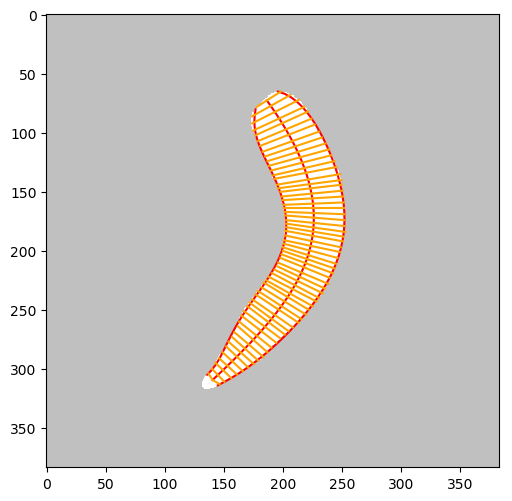

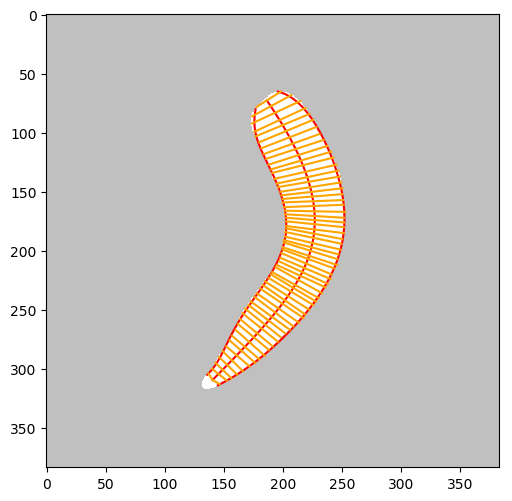

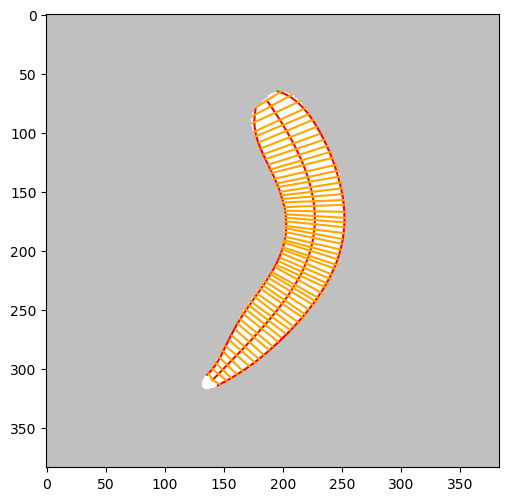

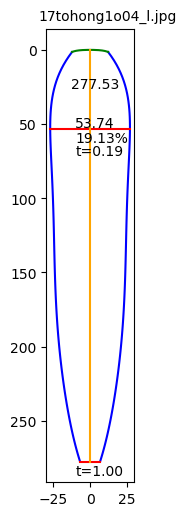

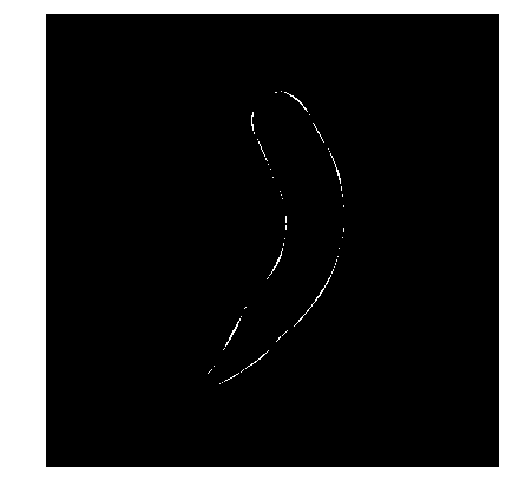

In [6]:
%time
%time automeasure2(datafile = '計測指示＆記録.xlsx', savedir='伸身シルエットR', target=1, saveImage=True)
print("");

In [7]:
df.to_excel('自動計測データ.xlsx', index=True, header=True)

In [8]:
df.to_excel('自動計測データ2.xlsx', index=True, header=True)

# 幅計測と中心軸近似の緩和的繰り返し

![Alt text](https://monosnap.com/image/1b2yYy1Lsi5sZut0WpCwRBwYXvdqRG.png)
![Alt text](https://monosnap.com/image/sJWXlw8JILWU80lYy9q1EdznGaTaSW.png)

処理の中程で、
「中心軸→幅→中心軸の緩和的繰り返しを２回」
という部分があります。

左右輪郭の近似曲線の平均を取る形で中心軸を求め、その中心軸上の点の法線方向の直線を左右の輪郭で切り取った線分をその点での幅と定義します。 

理想的には中心軸はこの線分の中点を通って欲しいのですが、そうはなっていません。そこで、線分が求まったらその中心をサンプル店として点列を作り、その点列をベジエ曲線で近似することで、より中心に近い位置の軸を得ます。その軸を使って再び幅を求め、その幅の中心を使って中心軸を再度求める、ということを繰り返しています。

何度か繰り返してみたところ、あまりたくさんの回数繰り返すと輪郭の凹凸に過剰に影響されてあまり良い結果とならないことがわかりました。
上図は３回繰り返した様子で、処理順は左から右の順です。１回目は幅線の間隔の疎密の差が大きく、密になって欲しいところと疎で良いところが逆転しているような結果ですが、２回目は比較的間隔が均等になり、３回目と２回目の差はあまりありません。ということで、この処理は２回が適当かなと思います。

In [9]:
test = np.array([[[80,80]],[[40,120]],[[80,160]],[[120,200]],[[80,240]],[[40,200]],[[80,160]],[[120,120]]])

In [10]:
aaa = np.zeros((300,300),np.uint8)

In [11]:
bbb = cv2.drawContours(aaa,[test],-1,255,-1)

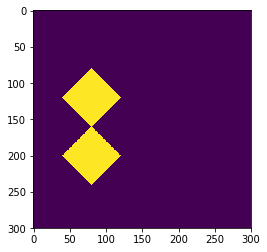

In [12]:
plt.imshow(bbb)

In [13]:
a = np.array([1,2,3,4])

In [14]:
RPARA

0.7

In [15]:
import rdlib2
from rdlib2 import *

In [16]:
assertglobal(params={'SHRINK':0.9})

In [17]:
SHRINK

0.8